# distance -> leave-one-out for tm helices -> check dist

In [1]:
from Bio.PDB import *
from Bio.PDB.PDBExceptions import PDBConstructionWarning

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from pdb_io import parse_PDB, position_model
from geometry import calculate_angle, make_vectors_cone, get_rotation
from q_value import calc_Q_value

import warnings

In [2]:
def extract_helices_from_PDB(filepath):
    file = open(filepath, "r")
    lines = file.read().split("\n")
    
    index = 0
    helices = []
    while not lines[index].startswith("HELIX"):
        index += 1
    while lines[index].startswith("HELIX"):
        line = lines[index]
        chain, start, end = line[19], int(line[21:25]), int(line[33:37])
        if (chain, start, end) not in helices:
            helices.append((chain, start, end))
        index += 1
    file.close()
    return helices

In [3]:
def calc_helix_geometry(helix):
    chain, start, end = helix
    helix_CO_bonds = []
    helix_CAs = []
    if end-start+1 < 8:
        return None, None
    else:
        for i in range(start, end+1):
            try:
                helix_CO_bonds.append(model[chain][i]['O'].coord - model[chain][i]['C'].coord)
                helix_CAs.append(model[chain][i]['CA'].coord)
            except KeyError:
                continue
            
    sum_vector = sum(helix_CO_bonds)
    
    deviation_angles = [calculate_angle(sum_vector, bond, True) for bond in helix_CO_bonds]
        
    angle_mean = np.mean(deviation_angles)
    angle_std = np.std(deviation_angles)
    
    final_helix_CO_bonds = [helix_CO_bonds[i] for i in range(len(helix_CO_bonds))
                            if abs(deviation_angles[i]-angle_mean) < angle_std]
    
    helix_direction = sum(final_helix_CO_bonds)
    helix_direction = helix_direction / np.linalg.norm(helix_direction)
    helix_center = sum(helix_CAs) / (1.0*len(helix_CAs))

    return helix_center, helix_direction



    
def calculate_projected_dist(a_pos, a_dir, b_pos, b_dir):
    common_dir = a_dir + b_dir*np.sign(np.dot(a_dir , b_dir))
    common_dir = common_dir / np.linalg.norm(common_dir)
    
    center_dist = np.abs(np.dot(a_pos, common_dir) - np.dot(b_pos, common_dir))
    
    return center_dist

def distance_function(a_dir, a_pos, b_dir, b_pos):
    return  1- np.abs(np.cos( calculate_angle(a_dir, b_dir) )) + calculate_projected_dist(a_pos, a_dir, b_pos, b_dir) / 15
    
    
    

In [318]:
print(helices)

[('A', 4, 9), ('A', 51, 62), ('A', 72, 82), ('A', 103, 118), ('A', 124, 143), ('A', 145, 157), ('A', 162, 164), ('A', 171, 176), ('A', 179, 190), ('A', 205, 211), ('A', 224, 226), ('A', 265, 277), ('A', 287, 289), ('A', 293, 300), ('A', 331, 348), ('A', 351, 369), ('A', 372, 385), ('A', 392, 401), ('A', 404, 414), ('A', 434, 441), ('B', 55, 57), ('B', 65, 71), ('B', 82, 92), ('B', 113, 128), ('B', 134, 153), ('B', 155, 167), ('B', 183, 185), ('B', 188, 198), ('B', 201, 203), ('B', 213, 223), ('B', 267, 279), ('B', 294, 302), ('B', 333, 348), ('B', 354, 372), ('B', 375, 388), ('B', 395, 404), ('B', 407, 418), ('C', 5, 8), ('C', 10, 18), ('C', 29, 31), ('C', 33, 53), ('C', 62, 72), ('C', 76, 104), ('C', 106, 108), ('C', 110, 133), ('C', 137, 152), ('C', 157, 165), ('C', 172, 202), ('C', 214, 216), ('C', 222, 244), ('C', 272, 282), ('C', 287, 307), ('C', 315, 317), ('C', 319, 340), ('C', 345, 363), ('C', 365, 376), ('D', 23, 36), ('D', 58, 71), ('D', 74, 76), ('D', 98, 104), ('D', 113, 11

In [4]:
# Parse Model, get helices
model = parse_PDB('./structures_helices/1be3.pdb')
model, prev_pos = position_model(model)


helices = extract_helices_from_PDB('./structures_helices/1be3.pdb')

# Manually checked, long helixes inside membrane
tm = [('C', 33),('C', 76),('C', 110),('C', 172),('C', 222),
      ('C', 287),('C', 319),('C', 345),('C', 365),('D', 204),
      ('E', 26),('G', 29),('J', 17),('K', 16)]

# Get labels, vectors and centers of each helix
labels = [(helix[0], helix[1]) in tm for helix in helices]

helix_vectors = []
helix_centers = []

for helix in helices:
    dicti = calc_helix_geometry(helix)
    helix_vectors.append(dicti[1])
    helix_centers.append(dicti[0])

In [5]:
print(prev_pos)

[ 32.23923999 127.88527506  21.56395075]


In [6]:
helix_df = pd.DataFrame({'helix':helices, 'label':labels, 'direction':helix_vectors, 'center':helix_centers})
helix_df = helix_df.dropna()
helix_df_tm = helix_df[helix_df['label']]
helix_df_not_tm = helix_df[[not i for i in helix_df['label']]]

In [151]:
#[[i[0],i[1],i[2]] for i in helix_df['direction']]

In [6]:
angle_matrix_all = [[1- np.abs(np.cos( calculate_angle(helix_df.loc[i,'direction'], helix_df.loc[j,'direction'], True) ) )
                     for j in helix_df.index] for i in helix_df.index]

angle_matrix_tm = [[1- np.abs(np.cos( calculate_angle(helix_df_tm.loc[i,'direction'], helix_df_tm.loc[j,'direction'], True)))
                     for j in helix_df_tm.index] for i in helix_df_tm.index]

dist_matrix_all = [[distance_function(helix_df.loc[i,'direction'], helix_df.loc[i,'center'], 
                                             helix_df.loc[j,'direction'], helix_df.loc[j,'center'])
                 for j in helix_df.index] for i in helix_df.index]

dist_matrix_tm = [[distance_function(helix_df_tm.loc[i,'direction'], helix_df_tm.loc[i,'center'], 
                                             helix_df_tm.loc[j,'direction'], helix_df_tm.loc[j,'center'])
                 for j in helix_df_tm.index] for i in helix_df_tm.index]

In [9]:
from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list('mycmap', 
        [(0,'#113377'),(1/6,'#66dd33'),(2/6,'#ffdd99'),(0.5,'white'),(4/6,'#ffdd99'),(5/6,'#66dd33'),(1,'#113377')])


def make_heatmap(dist_matrix, subplot, vmax, cmap, labels, title):
    
    plt.subplot(subplot)
    plt.imshow(dist_matrix, cmap=cmap, vmax=vmax);
    plt.colorbar();
    plt.title(title);
    plt.xticks(range(len(labels)),labels, rotation='vertical');
    plt.yticks(range(len(labels)),labels, rotation='horizontal');
    plt.gca().xaxis.tick_bottom();
    plt.tick_params(labelsize=8);
    
"""
plt.subplots(ncols=2, nrows=2, figsize=(20,20))
make_heatmap(angle_matrix_all, 221, 1, 'CMRmap_r', helix_df['label'], "1BE3 Angles [transformed]")
make_heatmap(angle_matrix_tm, 223, 1, 'CMRmap_r', helix_df_tm['label'], "1BE3 Angles [transformed]")
make_heatmap(dist_matrix_all, 222, 2, 'CMRmap_r', helix_df['label'], "1BE3 New Dist. function")
make_heatmap(dist_matrix_tm, 224, 2, 'CMRmap_r', helix_df_tm['label'], "1BE3 New Dist. function")
"""

'\nplt.subplots(ncols=2, nrows=2, figsize=(20,20))\nmake_heatmap(angle_matrix_all, 221, 1, \'CMRmap_r\', helix_df[\'label\'], "1BE3 Angles [transformed]")\nmake_heatmap(angle_matrix_tm, 223, 1, \'CMRmap_r\', helix_df_tm[\'label\'], "1BE3 Angles [transformed]")\nmake_heatmap(dist_matrix_all, 222, 2, \'CMRmap_r\', helix_df[\'label\'], "1BE3 New Dist. function")\nmake_heatmap(dist_matrix_tm, 224, 2, \'CMRmap_r\', helix_df_tm[\'label\'], "1BE3 New Dist. function")\n'

In [12]:
# test distances of helices to TM helix average
total_direction, total_center = average_direction_center(helix_df_tm)
blah1 = [distance_function(total_direction, total_center, 
                           helix_df_tm.loc[i,'direction'], helix_df_tm.loc[i,'center'])
        for i in helix_df_tm.index]


blah2 = [distance_function(total_direction, total_center, 
                           helix_df_not_tm.loc[i,'direction'], helix_df_not_tm.loc[i,'center'])
        for i in helix_df_not_tm.index]

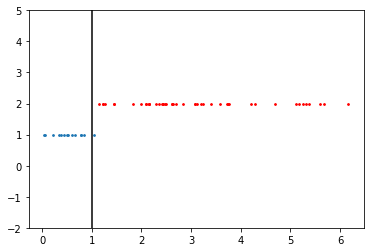

In [13]:
plt.scatter(blah1, [1]*len(blah1), s=3)
plt.scatter(blah2, [2]*len(blah2), s=3, color='red')
plt.vlines(x=1, ymin=-2, ymax=5)
plt.ylim([-2,5]);

In [4]:
def average_direction_center(helix_tm):
    total_direction = helix_tm.loc[helix_tm.index[0],'direction']
    total_center = helix_tm.loc[helix_tm.index[0],'direction']
    
    for helix in helix_tm.index[1:]:
        total_direction = total_direction + (helix_tm.loc[helix,'direction']
                                             * np.sign(np.dot(helix_tm.loc[helix,'direction'], total_direction)))
        total_center = total_center + helix_tm.loc[helix,'center']
            
    total_direction = total_direction / np.linalg.norm(total_direction)
    total_center = total_center / len(helix_tm.index)
    
    return total_direction, total_center

    
    
def filter_outlier_helices(helix_tm, cutoff=1):
    helix_tm2 = helix_tm.copy()
    total_direction, total_center = average_direction_center(helix_tm2)
    outliers = [helix for helix in helix_tm2.index
               if distance_function(total_direction, total_center, 
                                  helix_tm2.loc[helix,'direction'], helix_tm2.loc[helix,'center']) > cutoff]
    print(outliers)
    while len(outliers) > 0:
        helix_tm2 = helix_tm2.drop(outliers)
        total_direction, total_center = average_direction_center(helix_tm2)
        outliers = [helix for helix in helix_tm2.index
                    if distance_function(total_direction, total_center, 
                                         helix_tm2.loc[helix,'direction'], helix_tm2.loc[helix,'center']) > cutoff]
        print(outliers)
    return total_direction, total_center

    
#total_direction, total_center = filter_outlier_helices(helix_df_tm, 1.1) # or 1.0 ??
#print(total_direction, total_center)

In [31]:
def get_max_sliding_window(scores, window=15):
    avgs = [sum(scores[i:(i+window)])/window for i in range(len(scores)-window)]

    max_score = max(avgs)
    max_index = np.argmax(avgs)
    
    return max_score, max_index, avgs
    
#max_score, max_index, avgs = get_max_sliding_window(slice_scores1, 20)


def optimise_vector(model, vector, window_size=15):
    test_vectors = make_vectors_cone(vector, 15, 2)
    
    best_vector = vector
    best_slice_scores, best_z_min, best_z_max = calc_Q_value(model, vector)
    best_score, best_max_index, best_avgs = get_max_sliding_window(best_slice_scores, window_size)
    print(best_vector, best_score)
    
    for test_vector in test_vectors:
        test_slice_scores, test_z_min, test_z_max = calc_Q_value(model, np.array(test_vector))

        test_score, test_max_index, test_avgs = get_max_sliding_window(test_slice_scores, window_size) 
        
        if test_score > best_score:
            best_vector = test_vector
            best_score = test_score
            best_z_min = test_z_min
            best_z_max = test_z_max
            best_max_index = test_max_index
            best_avgs = test_avgs
            best_slice_scores = test_slice_scores

    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(range(best_z_min, best_z_max), best_slice_scores)
    ax.set_title("[%1.3f, %1.3f, %1.3f]"%(best_vector[0], best_vector[1], best_vector[2]))
    ax.set_xlabel('Cross Section')
    ax.set_ylabel('Q-score')
    for i, avg in enumerate(best_avgs):
        ax.plot([best_z_min+i, best_z_min+i+window_size], [avg, avg], color="red")
        
    return best_vector, best_score, best_slice_scores, best_avgs, fig

    
    
#best_vector, best_score, best_slice_scores, best_avgs = optimise_vector(model, total_direction, 15)

In [14]:
print(best_vector, best_score, best_max_index)

[0.808079090251242, -0.5561224489795918, 0.19425757550135908] 0.36914744616567247 5


In [6]:
# Parse Model, get helices
model = parse_PDB('./structures_helices/1clt.pdb')
model, prev_pos = position_model(model)


helices = extract_helices_from_PDB('./structures_helices/1clt.pdb')
#for hel in helices:
#    print(hel)

In [7]:
# Manually checked, long helixes inside membrane
tm = [('L', 33),('L', 84),('L', 116),('L', 171),('L', 226),
      ('M', 52),('M', 111),('M', 143),('M', 198),('M', 262)]

# Get labels, vectors and centers of each helix
labels = [(helix[0], helix[1]) in tm for helix in helices]

helix_vectors = []
helix_centers = []

for helix in helices:
    dicti = calc_helix_geometry(helix)
    helix_vectors.append(dicti[1])
    helix_centers.append(dicti[0])

In [8]:
helix_df = pd.DataFrame({'helix':helices, 'label':labels, 'direction':helix_vectors, 'center':helix_centers})
helix_df = helix_df.dropna()
helix_df_tm = helix_df[helix_df['label']]
helix_df_not_tm = helix_df[[not i for i in helix_df['label']]]

[]
[120.7437785   65.57580234   8.3591867 ]
[-0.5070215  -0.7417405   0.43903329] [ 2.7289882  -0.35099164 -0.58742261]
[-0.5070215  -0.7417405   0.43903329] 0.48751545717638683


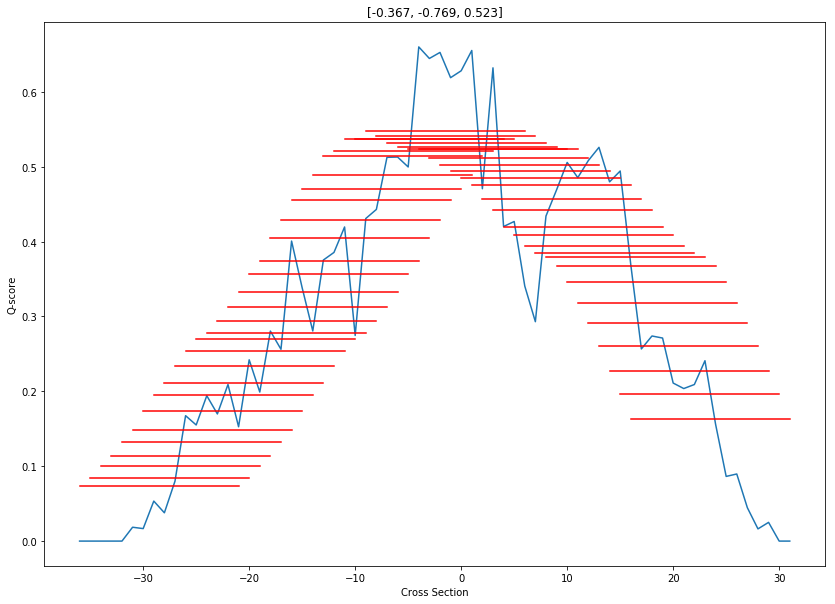

In [30]:
total_direction, total_center = filter_outlier_helices(helix_df_tm, 1.1) # or 1.0 ??
print(prev_pos)
print(total_direction, total_center)


best_vector, best_score, best_slice_scores, best_avgs, fig = optimise_vector(model, total_direction, 15)
fig.savefig("./test.png")